In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


In [2]:
class SignalEditor:
    def __init__(self, signals, times, channel_names,
                 window_sec=20, n_display=20):
        """
        signals: np.ndarray (n_channels, n_times)
        times: np.ndarray (n_times,)
        channel_names: list of str (n_channels,)
        """
        self.signals = signals
        self.times = times
        self.channel_names = channel_names

        self.n_channels, self.n_times = signals.shape

        # Parameters
        self.window_sec = window_sec
        self.n_display = n_display
        self.start_time = times[0]
        self.current_time = times[0]
        self.current_chan_start = 0
        self.gain = 1.0

        # Derived
        self.fs = 1 / np.mean(np.diff(times))

        self._init_plot()

    def _init_plot(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 8))
        plt.subplots_adjust(bottom=0.25)

        self.lines = []
        self._plot_signals()

        # --- Slider (scroll temporel)
        ax_slider = plt.axes([0.2, 0.1, 0.6, 0.03])
        self.slider = Slider(ax_slider, "Temps",
                             self.times[0],
                             self.times[-1] - self.window_sec,
                             valinit=self.current_time)
        self.slider.on_changed(self._on_scroll)

        # --- Boutons
        ax_zoom_in = plt.axes([0.82, 0.1, 0.05, 0.04])
        ax_zoom_out = plt.axes([0.88, 0.1, 0.05, 0.04])
        ax_next = plt.axes([0.82, 0.16, 0.11, 0.04])
        ax_prev = plt.axes([0.82, 0.22, 0.11, 0.04])

        self.btn_zoom_in = Button(ax_zoom_in, "+")
        self.btn_zoom_out = Button(ax_zoom_out, "-")
        self.btn_next = Button(ax_next, "Canaux +")
        self.btn_prev = Button(ax_prev, "Canaux -")

        self.btn_zoom_in.on_clicked(self._zoom_in)
        self.btn_zoom_out.on_clicked(self._zoom_out)
        self.btn_next.on_clicked(self._next_channels)
        self.btn_prev.on_clicked(self._prev_channels)

        plt.show()

    def _get_time_indices(self):
        t0 = self.current_time
        t1 = t0 + self.window_sec
        idx = np.where((self.times >= t0) & (self.times <= t1))[0]
        return idx

    def _plot_signals(self):
        self.ax.clear()

        idx = self._get_time_indices()
        ch_start = self.current_chan_start
        ch_end = min(ch_start + self.n_display, self.n_channels)

        offset = 0
        yticks = []
        ylabels = []

        for ch in range(ch_start, ch_end):
            sig = self.signals[ch, idx] * self.gain
            t = self.times[idx]

            self.ax.plot(t, sig + offset, lw=1)
            yticks.append(offset)
            ylabels.append(self.channel_names[ch])
            offset += np.max(np.abs(sig)) * 2 + 1e-6

        self.ax.set_xlabel("Temps (s)")
        self.ax.set_yticks(yticks)
        self.ax.set_yticklabels(ylabels)
        self.ax.set_title("Éditeur de signal multicanal")
        self.ax.grid(True)

        self.fig.canvas.draw_idle()

    def _on_scroll(self, val):
        self.current_time = val
        self._plot_signals()

    def _zoom_in(self, event):
        self.gain *= 1.2
        self._plot_signals()

    def _zoom_out(self, event):
        self.gain /= 1.2
        self._plot_signals()

    def _next_channels(self, event):
        self.current_chan_start += self.n_display
        if self.current_chan_start >= self.n_channels:
            self.current_chan_start = self.n_channels - self.n_display
        self.current_chan_start = max(0, self.current_chan_start)
        self._plot_signals()

    def _prev_channels(self, event):
        self.current_chan_start -= self.n_display
        if self.current_chan_start < 0:
            self.current_chan_start = 0
        self._plot_signals()


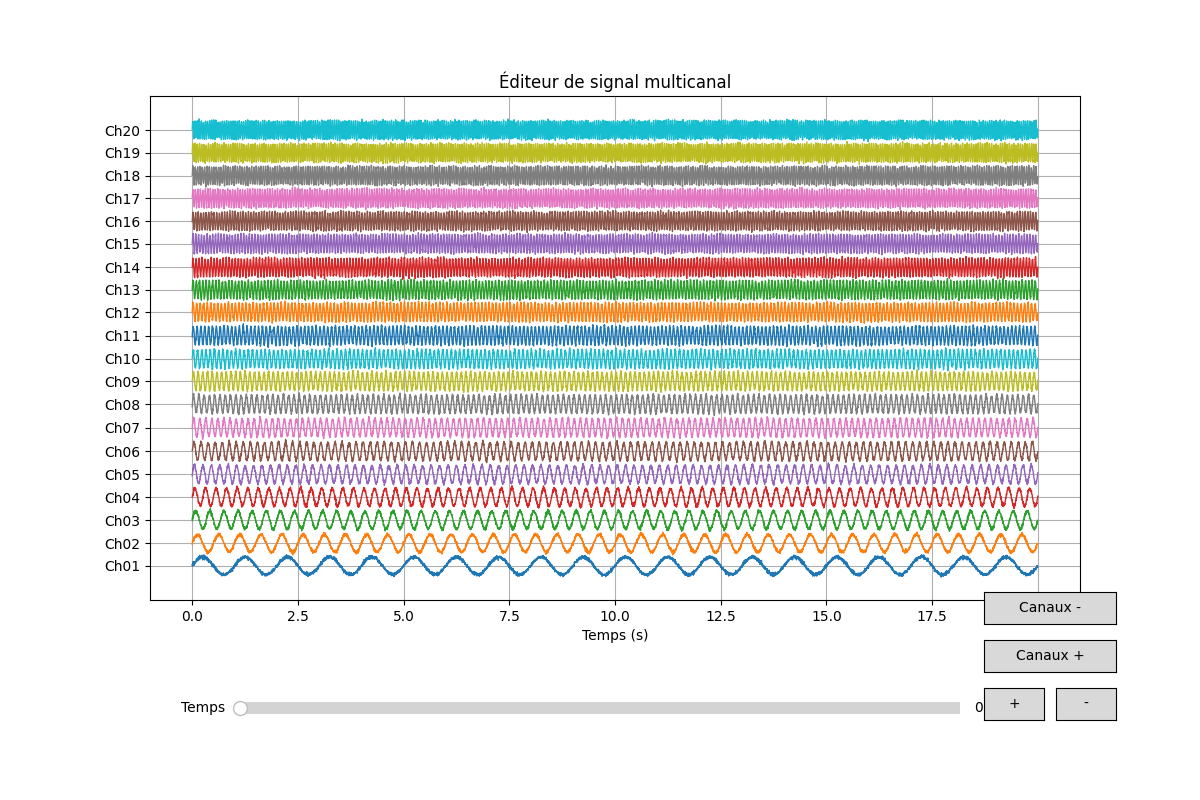

In [4]:
%matplotlib qt


# --- Génération de signaux factices pour test
fs = 250  # Hz
duration = 120  # secondes
times = np.arange(0, duration, 1/fs)

n_channels = 64
signals = np.array([
    np.sin(2 * np.pi * (i+1) * times) + 0.1 * np.random.randn(len(times))
    for i in range(n_channels)
])

channel_names = [f"Ch{i+1:02d}" for i in range(n_channels)]

# --- Lancement de l'éditeur
editor = SignalEditor(signals, times, channel_names,
                      window_sec=20, n_display=20)
